In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Time series analysis libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# PART 1: DATA GENERATION AND EXPLORATION

In [4]:
def generate_network_traffic_data(days=365, noise_level=0.1):
    """
    Synthesize hourly network-traffic data that feels realistic by combining:
      • A daily cycle (higher usage during business hours)
      • A weekly pattern (lighter traffic on weekends)
      • A gentle long-term trend (slow growth over time)
      • Random noise + occasional spikes (congestion/incidents)

    Returns a DataFrame with:
      - timestamp (DatetimeIndex-compatible column)
      - traffic_mbps (float): simulated Mbps values
      - hour (int 0–23): hour of day
      - weekday (int 0–6): Monday=0 ... Sunday=6
      - day_of_year (int 1–366)
    """

    # Build an hourly timeline for `days` worth of data starting Jan 1, 2023
    start_date = datetime(2023, 1, 1)
    dates = pd.date_range(start=start_date, periods=days * 24, freq="H")

    # --- Baselines & calendar features ---
    # Small tweak: raise baseline from 100 → 150 to reflect a busier network.
    base_traffic = 150

    # Convert calendar features to *NumPy arrays* to avoid immutable Index behavior
    hours = dates.hour.to_numpy()
    weekdays = dates.weekday.to_numpy()
    day_of_year = dates.dayofyear.to_numpy()

    # --- Daily pattern (business hours) ---
    # Slightly widen business hours from 8–18 to 7–19 to better capture ramps.
    business_hours = ((hours >= 7) & (hours <= 19)).astype(float)
    # Peak lift during business hours; smooth sinus adds intra-day curvature.
    daily_boost = 40 * business_hours + 10 * np.sin(2 * np.pi * hours / 24.0)

    # --- Weekly pattern ---
    # Lower traffic on weekends (Sat=5, Sun=6). Weekday lift is modest.
    is_weekend = (weekdays >= 5).astype(float)
    weekly_adjust = -25 * is_weekend + 8 * (1 - is_weekend)

    # --- Long-term trend ---
    # Slow, almost linear growth over the entire period.
    trend = 0.02 * np.arange(len(dates))

    # --- Random noise ---
    # Gaussian noise scaled by `noise_level`. Keeping it small preserves structure.
    noise = np.random.normal(loc=0.0, scale=10 * noise_level, size=len(dates))

    # --- Combine components into traffic series ---
    # Ensure we get a *mutable* NumPy array (not a Pandas Index) for in-place edits.
    traffic = np.asarray(base_traffic + daily_boost + weekly_adjust + trend + noise, dtype=float)

    # --- Anomalies / spikes (rare congestion events) ---
    # Keep frequency the same but slightly trim average spike size to be subtle.
    spike_indices = np.random.choice(len(dates), size=int(len(dates) * 0.01), replace=False)
    traffic[spike_indices] += np.random.exponential(scale=45, size=len(spike_indices))  # 50 → 45

    # Floor to avoid negative or near-zero nonsense readings
    traffic = np.maximum(traffic, 5)

    # Return as a tidy frame with extra calendar features for downstream models
    return pd.DataFrame({
        "timestamp": dates,
        "traffic_mbps": traffic.astype(float),
        "hour": hours.astype(int),
        "weekday": weekdays.astype(int),
        "day_of_year": day_of_year.astype(int),
    })

In [5]:
# Create the synthetic dataset and set a time-based index so plotting and
# time-series operations behave naturally. Using the default 365-day span.
print("Generating network traffic dataset...")
df = generate_network_traffic_data(days=365)

# Make 'timestamp' the index for time-series convenience
df.set_index("timestamp", inplace=True)

# Helpful sanity checks to confirm shape and coverage
print(f"Dataset shape (rows, cols): {df.shape}")
print(f"Date range: {df.index.min()}  →  {df.index.max()}")

# Quick look at the first few records to verify columns and plausible values
print("\nSample rows:")
print(df.head())

Generating network traffic dataset...
Dataset shape (rows, cols): (8760, 4)
Date range: 2023-01-01 00:00:00  →  2023-12-31 23:00:00

Sample rows:
                     traffic_mbps  hour  weekday  day_of_year
timestamp                                                    
2023-01-01 00:00:00    125.496714     0        6            1
2023-01-01 01:00:00    127.469926     1        6            1
2023-01-01 02:00:00    130.687689     2        6            1
2023-01-01 03:00:00    133.654098     3        6            1
2023-01-01 04:00:00    133.506101     4        6            1


# PART 2: EXPLORATORY DATA ANALYSIS

In [6]:
def perform_eda(df):
    """
    Perform a quick but comprehensive EDA on the time-indexed traffic dataset.
    What this does:
      • Prints summary statistics for the target variable (traffic_mbps)
      • Creates several standard visualizations in a 2×2 grid (time series, distribution, etc.)
      • Runs a seasonal decomposition to separate trend/seasonal/residual components
      • Returns the decomposition object for potential downstream inspection
    Expected input:
      - df: pandas DataFrame with a DatetimeIndex and a 'traffic_mbps' numeric column.
    """

    # Section header to make console output easy to scan
    print("\n" + "="*50)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*50)

    # 1) BASIC DESCRIPTIVE STATS
    # Quickly assess central tendency, dispersion, and range of traffic values.
    print("\nBasic Statistics:")
    print(df['traffic_mbps'].describe())

    # 2) OVERVIEW PLOTS (2×2 GRID)
    # Create a figure with four subplots so we can compare views side-by-side.
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 2a) TIME SERIES VIEW
    # See how traffic evolves over the full period; alpha makes overlapping lines less harsh.
    axes[0,0].plot(df.index, df['traffic_mbps'], alpha=0.7)
    axes[0,0].set_title('Traffic Over Time')
    axes[0,0].set_xlabel('Timestamp')
    axes[0,0].set_ylabel('Mbps')

    # 2b) DISTRIBUTION VIEW
    # Histogram reveals whether the data are skewed, heavy-tailed, or near-normal.
    axes[0,1].hist(df['traffic_mbps'], bins=30, edgecolor='k', alpha=0.7)
    axes[0,1].set_title('Distribution of Traffic (Mbps)')
    axes[0,1].set_xlabel('Mbps')
    axes[0,1].set_ylabel('Count')

    # 2c) HOURLY AGGREGATE
    # Group by hour-of-day to inspect the daily usage cycle pattern.
    df.groupby(df.index.hour)['traffic_mbps'].mean().plot(ax=axes[1,0])
    axes[1,0].set_title('Average Traffic by Hour of Day')
    axes[1,0].set_xlabel('Hour (0–23)')
    axes[1,0].set_ylabel('Average Mbps')

    # 2d) WEEKDAY AGGREGATE
    # Group by day-of-week (Mon=0..Sun=6) to see weekday vs weekend behavior.
    df.groupby(df.index.weekday)['traffic_mbps'].mean().plot(ax=axes[1,1])
    axes[1,1].set_title('Average Traffic by Weekday')
    axes[1,1].set_xlabel('Weekday (Mon=0)')
    axes[1,1].set_ylabel('Average Mbps')

    # Tighten layout so titles/labels do not overlap.
    plt.tight_layout()
    plt.show()

    # 3) SEASONAL DECOMPOSITION
    # Break the series into trend + seasonal + residual components to make
    # weekly (24*7) seasonality explicit. The 'additive' model assumes
    # traffic ≈ trend + seasonal + residual.
    print("\nPerforming seasonal decomposition...")
    decomposition = seasonal_decompose(
        df['traffic_mbps'],
        model='additive',
        period=24*7  # weekly seasonality (hours per week)
    )

    # Plot each component in its own row to visually inspect structure and noise.
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    decomposition.observed.plot(ax=axes[0], title='Original')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')
    plt.tight_layout()
    plt.show()

    # Return the decomposition object so callers can reuse components if needed.
    return decomposition


EXPLORATORY DATA ANALYSIS

Basic Statistics:
count    8760.000000
mean      258.087309
std        56.298535
min       118.123156
25%       214.162417
50%       257.922111
75%       302.298398
max       540.879292
Name: traffic_mbps, dtype: float64


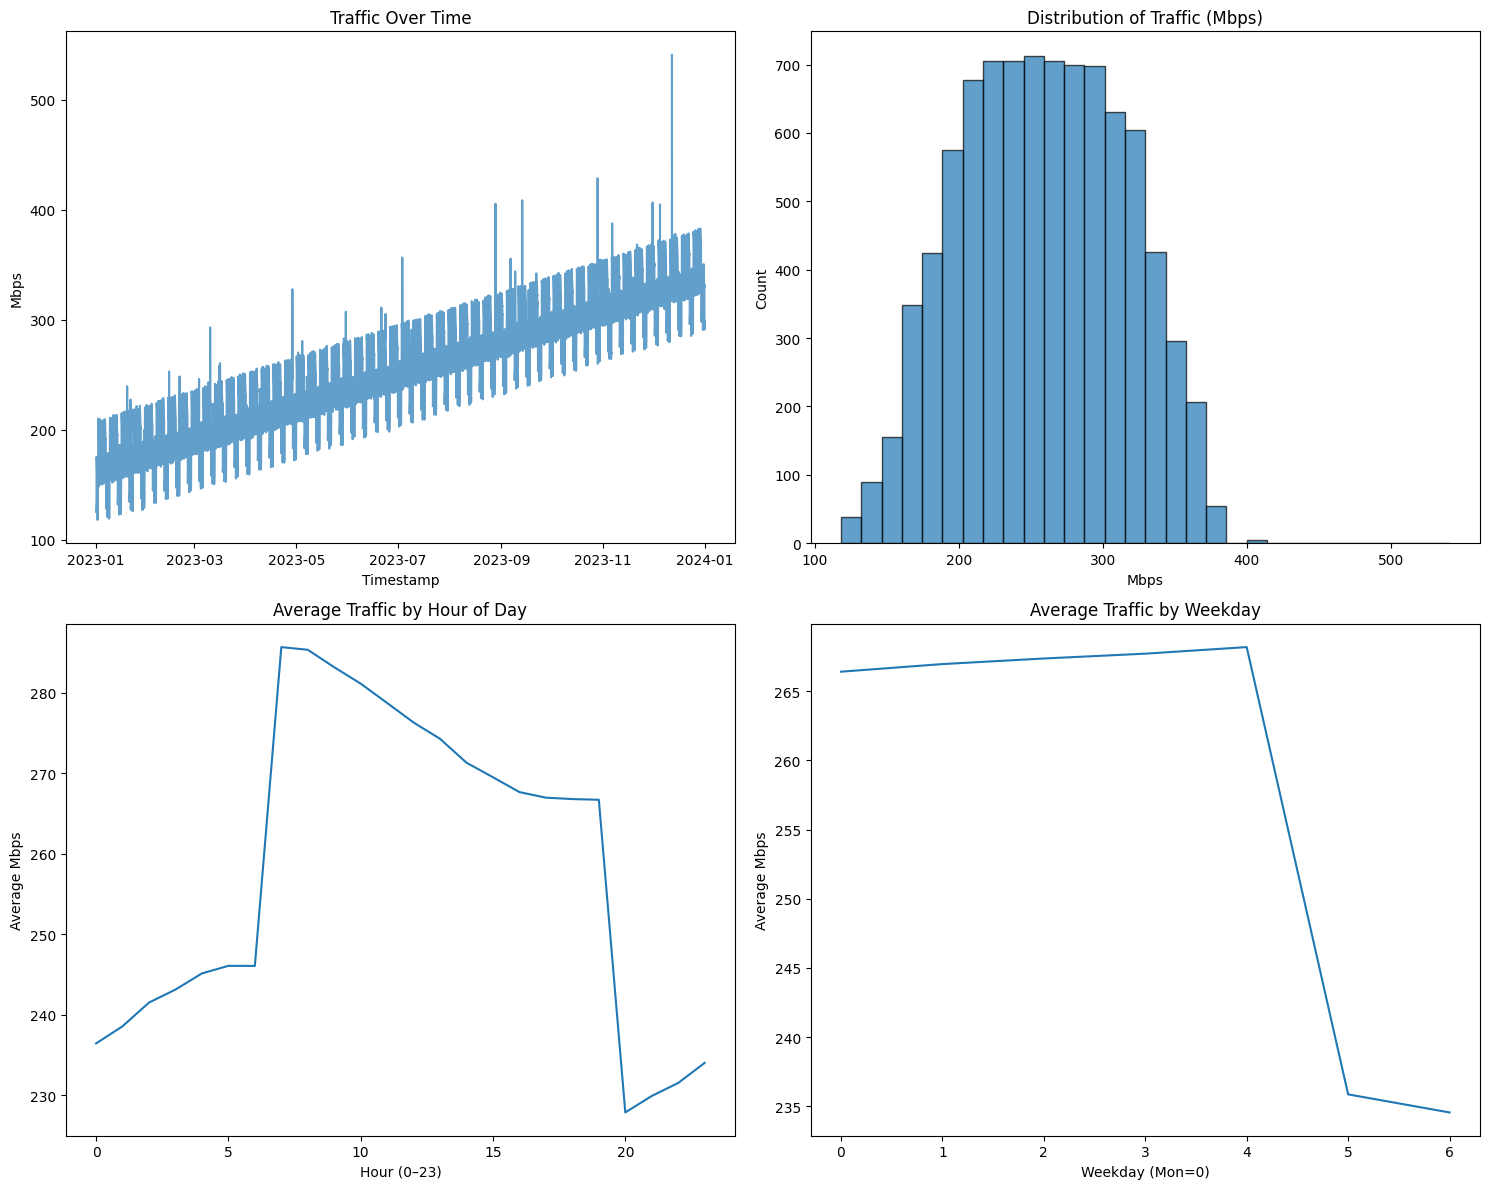


Performing seasonal decomposition...


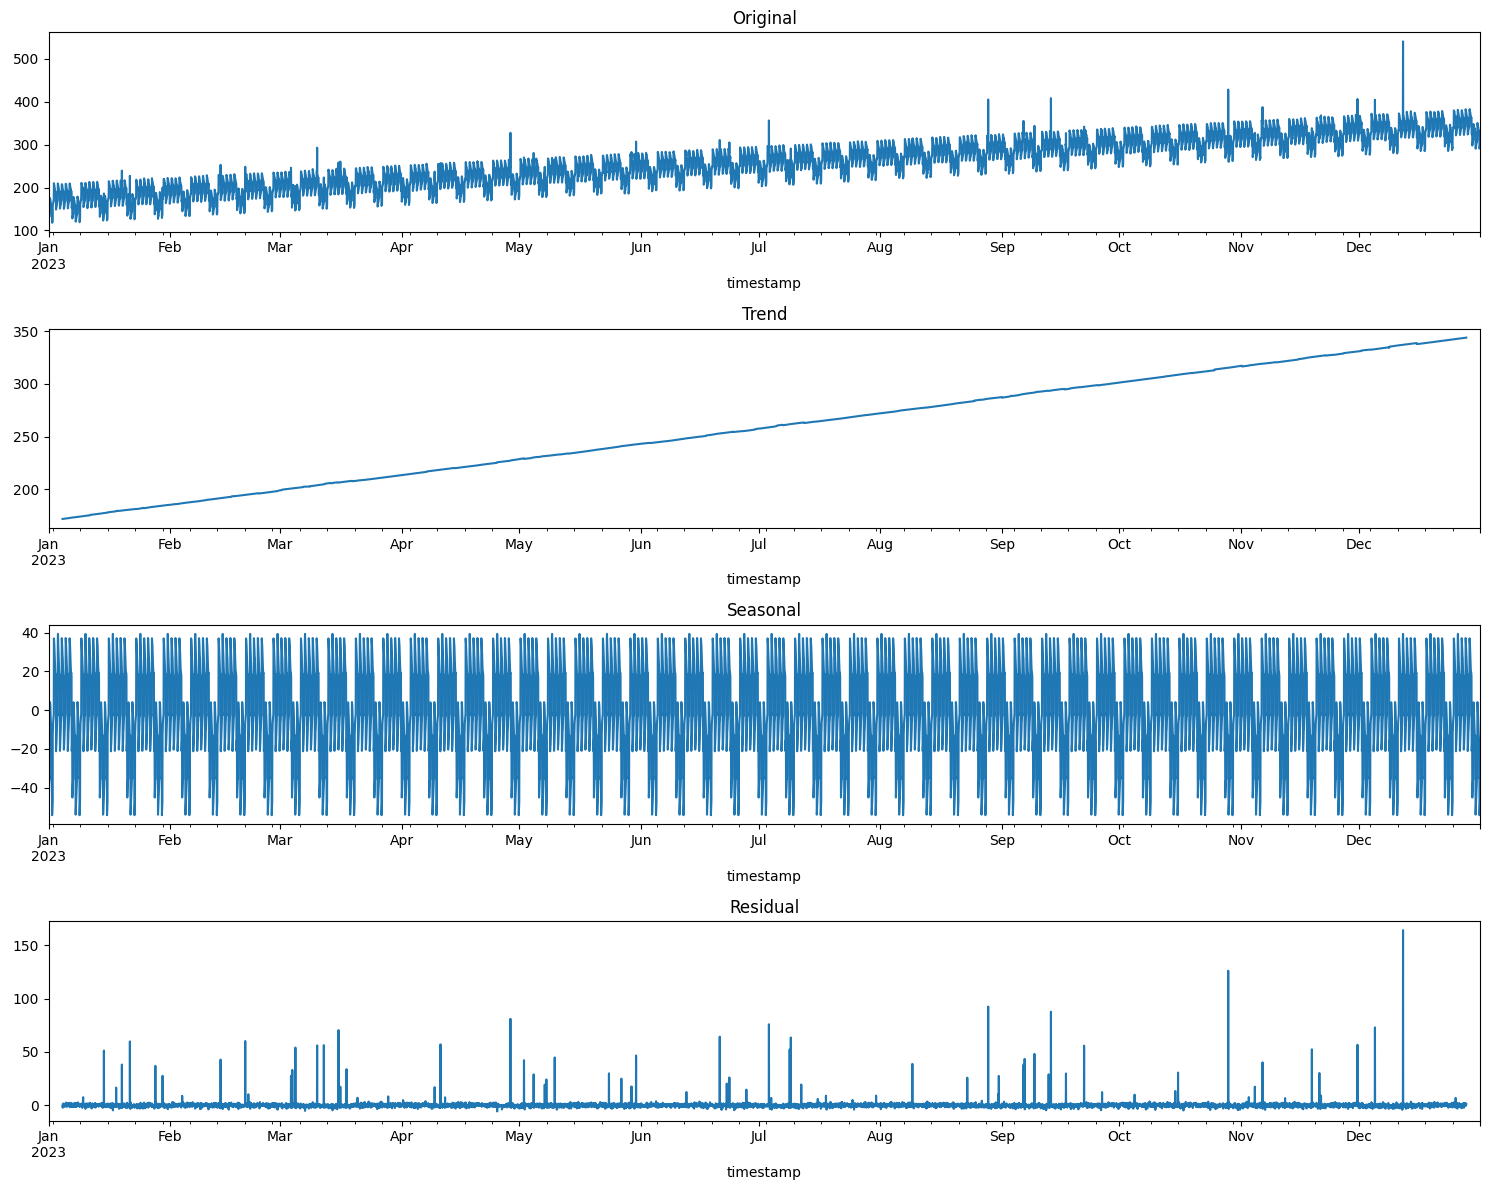

In [7]:
# Execute the EDA method we just defined
decomposition = perform_eda(df)

# PART 3: DATA PREPARATION FOR TIME SERIES MODELING

In [8]:
# Goal: create chronologically faithful train/test splits (to avoid data leakage)
# and perform a quick stationarity check on the training series using the
# Augmented Dickey-Fuller (ADF) test. The function returns the split DataFrames
# and a boolean flag indicating whether the training series appears stationary.

def prepare_data_for_modeling(df, train_ratio=0.8):
    """Split data into train/test sets and prepare features"""

    # Split data chronologically (no shuffling) so the model never sees the future.
    # The first `train_ratio` fraction is training; the remainder is held out as test.
    split_index = int(len(df) * train_ratio)
    train_data = df.iloc[:split_index].copy()
    test_data = df.iloc[split_index:].copy()

    # Basic audit of what went where, including time span and sample counts.
    print(f"\nData split:")
    print(f"Training set: {train_data.index.min()} to {train_data.index.max()} ({len(train_data)} samples)")
    print(f"Test set: {test_data.index.min()} to {test_data.index.max()} ({len(test_data)} samples)")

    # Define a helper that runs the ADF test on a univariate series.
    # Interpretation:
    #   • Null hypothesis: the series has a unit root (non-stationary)
    #   • If p-value <= 0.05: reject H0 → treat as stationary
    #   • If p-value  > 0.05: cannot reject H0 → treat as non-stationary
    # Note: This check is informational; we are not transforming the data here.
    def check_stationarity(timeseries, title):
        result = adfuller(timeseries.dropna())
        print(f'\n{title}:')
        print(f'ADF Statistic: {result[0]:.6f}')
        print(f'p-value: {result[1]:.6f}')
        if result[1] <= 0.05:
            print("Series is stationary")
        else:
            print("Series is non-stationary")
        return result[1] <= 0.05

    # Run the stationarity check specifically on the training portion of the target.
    is_stationary = check_stationarity(train_data['traffic_mbps'], 'Original Series')

    # Return split datasets and the stationarity flag for downstream modeling logic.
    return train_data, test_data, is_stationary

In [9]:
train_data, test_data, is_stationary = prepare_data_for_modeling(df)


Data split:
Training set: 2023-01-01 00:00:00 to 2023-10-19 23:00:00 (7008 samples)
Test set: 2023-10-20 00:00:00 to 2023-12-31 23:00:00 (1752 samples)

Original Series:
ADF Statistic: -3.830979
p-value: 0.002606
Series is stationary


# PART 4: MODEL 1 - ARIMA (AutoRegressive Integrated Moving Average)

In [10]:
def build_arima_model(train_data, test_data):
    """Build and evaluate ARIMA model"""

    print("\n" + "="*50)
    print("ARIMA MODEL")
    print("="*50)

    # Model choice note:
    # We use a fixed ARIMA(2,1,2) configuration here for simplicity.
    # p=2 (autoregressive lags), d=1 (first difference to handle non-stationarity),
    # q=2 (moving-average terms). Students can experiment with tuning later.
    print("\nBuilding ARIMA(2,1,2) model...")

    # Fit the ARIMA model on *training* target values only (no look-ahead to test)
    model = ARIMA(train_data['traffic_mbps'], order=(2,1,2))
    fitted_model = model.fit()

    # Summary provides coefficients, AIC, and diagnostics
    print("\nARIMA Model Summary:")
    print(fitted_model.summary())

    # --- Forecasting on the held-out test horizon ---
    # The number of steps equals the length of the test set so predictions align with test index
    print("\nMaking predictions on test set...")
    forecast = fitted_model.forecast(steps=len(test_data))

    # --- Error metrics on the test window ---
    # Mean Squared Error, Mean Absolute Error, and RMSE help quantify forecast accuracy
    mse = mean_squared_error(test_data['traffic_mbps'], forecast)
    mae = mean_absolute_error(test_data['traffic_mbps'], forecast)
    rmse = np.sqrt(mse)

    print(f"\nARIMA Model Performance:")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")

    # --- Visualization of historical train tail vs. test vs. forecast ---
    plt.figure(figsize=(15, 8))

    # Show the last 30 days from the training set for context
    plot_start = max(0, len(train_data) - 30*24)

    # Training tail (context window)
    plt.plot(train_data.index[plot_start:], train_data['traffic_mbps'].iloc[plot_start:],
             label='Training Data', alpha=0.7)
    # Ground-truth for the test period
    plt.plot(test_data.index, test_data['traffic_mbps'], label='Actual', alpha=0.8)
    # Forecast aligned to test index
    plt.plot(test_data.index, forecast, label='ARIMA Forecast', alpha=0.8)

    plt.title('ARIMA Model - Network Traffic Prediction')
    plt.xlabel('Date')
    plt.ylabel('Traffic (Mbps)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Return the fitted statsmodels object, the forecast series, and metrics for comparison
    return fitted_model, forecast, {'MSE': mse, 'MAE': mae, 'RMSE': rmse}


ARIMA MODEL

Building ARIMA(2,1,2) model...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)



ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:           traffic_mbps   No. Observations:                 7008
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -28038.888
Date:                Tue, 30 Sep 2025   AIC                          56087.776
Time:                        23:20:49   BIC                          56122.050
Sample:                    01-01-2023   HQIC                         56099.586
                         - 10-19-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1576      3.169     -0.050      0.960      -6.370       6.054
ar.L2          0.0355      0.225      0.157      0.875      -0.406       0.477
ma.L1          0.0518      3.1

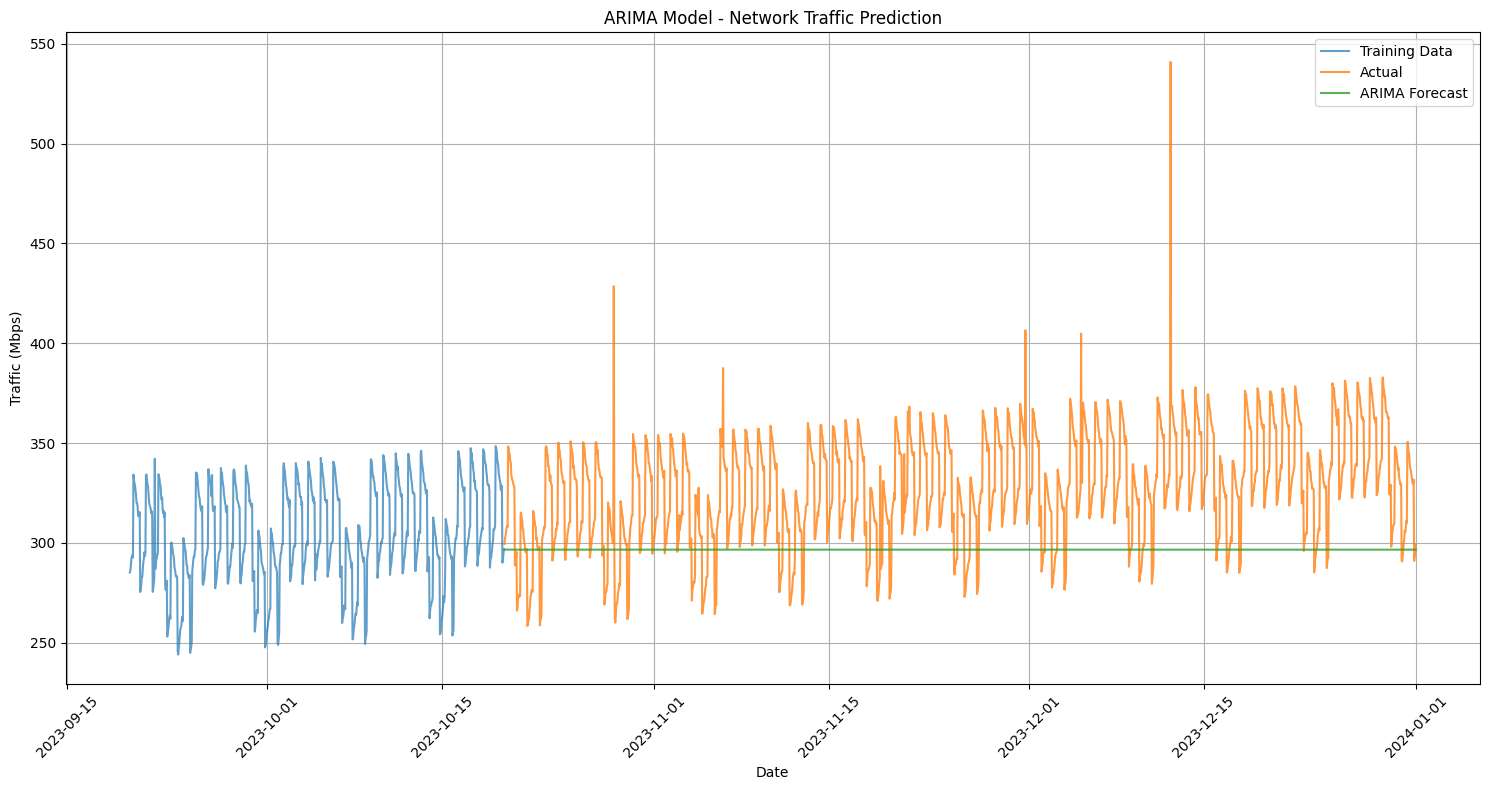

In [11]:
arima_model, arima_forecast, arima_metrics = build_arima_model(train_data, test_data)

# PART 5: MODEL 2 - LINEAR REGRESSION WITH ENGINEERED FEATURES

In [12]:
# Goal: Fit a *simple, fast* baseline using linear regression on hand-crafted
# time features (hour-of-day, day-of-week, etc.), then evaluate and visualize:
#   • Predictions vs. actuals on the test window
#   • Top coefficients (as a proxy for feature importance)

def build_linear_regression_model(train_data, test_data):
    """Build linear regression model with time-based features (baseline)"""

    print("\n" + "="*50)
    print("LINEAR REGRESSION MODEL WITH FEATURE ENGINEERING")
    print("="*50)

    # --- Feature engineering helper ---
    # Use cyclic encodings so that 23:00 and 00:00 are close on the circle,
    # and similarly for weekday cycles.
    def create_features(data):
        """Create time-based features for regression"""
        features_df = data.copy()

        # Time-based features (cyclic encodings for periodicity)
        features_df['hour_sin'] = np.sin(2 * np.pi * features_df['hour'] / 24)
        features_df['hour_cos'] = np.cos(2 * np.pi * features_df['hour'] / 24)
        features_df['weekday_sin'] = np.sin(2 * np.pi * features_df['weekday'] / 7)
        features_df['weekday_cos'] = np.cos(2 * np.pi * features_df['weekday'] / 7)

        return features_df

    # --- Prepare train/test design matrices ---
    # Apply the same feature construction to both splits (no look-ahead).
    train_feats = create_features(train_data)
    test_feats = create_features(test_data)

    # Select feature columns and the target.
    feature_cols = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']
    target_col = 'traffic_mbps'

    # Drop any rows with missing values (defensive; typically none after our generation)
    train_clean = train_feats[feature_cols + [target_col]].dropna()
    test_clean = test_feats[feature_cols + [target_col]].dropna()

    X_train = train_clean[feature_cols].values
    y_train = train_clean[target_col].values
    X_test = test_clean[feature_cols].values
    y_test = test_clean[target_col].values

    # --- Scale features (fit on train only) ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- Fit Linear Regression baseline ---
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)

    # --- Predict on the test window ---
    y_pred_test = lr_model.predict(X_test_scaled)

    # --- Evaluate numeric metrics ---
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_pred_test)

    print("\nLinear Regression Performance on Test Set:")
    print(f"MSE:  {test_mse:.2f}")
    print(f"MAE:  {test_mae:.2f}")
    print(f"RMSE: {test_rmse:.2f}")
    print(f"R^2:  {test_r2:.3f}")

    # --- Coefficient "importance" (absolute value as a simple proxy) ---
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': np.abs(lr_model.coef_)
    }).sort_values('importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

    # --- Visualization ---
    # Subplot 1: Actual vs Predicted on the test horizon (aligned to test index)
    # Subplot 2: Top coefficients by absolute magnitude (feature importance proxy)
    plt.figure(figsize=(15, 10))

    # Subplot 1 — Actual vs Predicted (time-aligned)
    plt.subplot(2, 1, 1)
    plt.plot(test_clean.index, y_test, label='Actual', alpha=0.85)
    plt.plot(test_clean.index, y_pred_test, label='LR Prediction', alpha=0.9)
    plt.title('Linear Regression — Predictions vs Actuals (Test Set)')
    plt.xlabel('Date')
    plt.ylabel('Traffic (Mbps)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

    # Subplot 2 — Feature Importance
    plt.subplot(2, 1, 2)
    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Absolute Coefficient Value')
    plt.title('Top 10 Feature Importance')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Return trained pieces for downstream reuse/inspection
    return lr_model, scaler, y_pred_test, test_clean.index, {
        'MSE': test_mse, 'MAE': test_mae, 'RMSE': test_rmse, 'R2': test_r2
    }


LINEAR REGRESSION MODEL WITH FEATURE ENGINEERING

Linear Regression Performance on Test Set:
MSE:  7970.85
MAE:  87.64
RMSE: 89.28
R^2:  -9.633

Top 10 Most Important Features:
       feature  importance
1     hour_cos   17.250129
2  weekday_sin   12.002796
3  weekday_cos    2.973446
0     hour_sin    2.275374


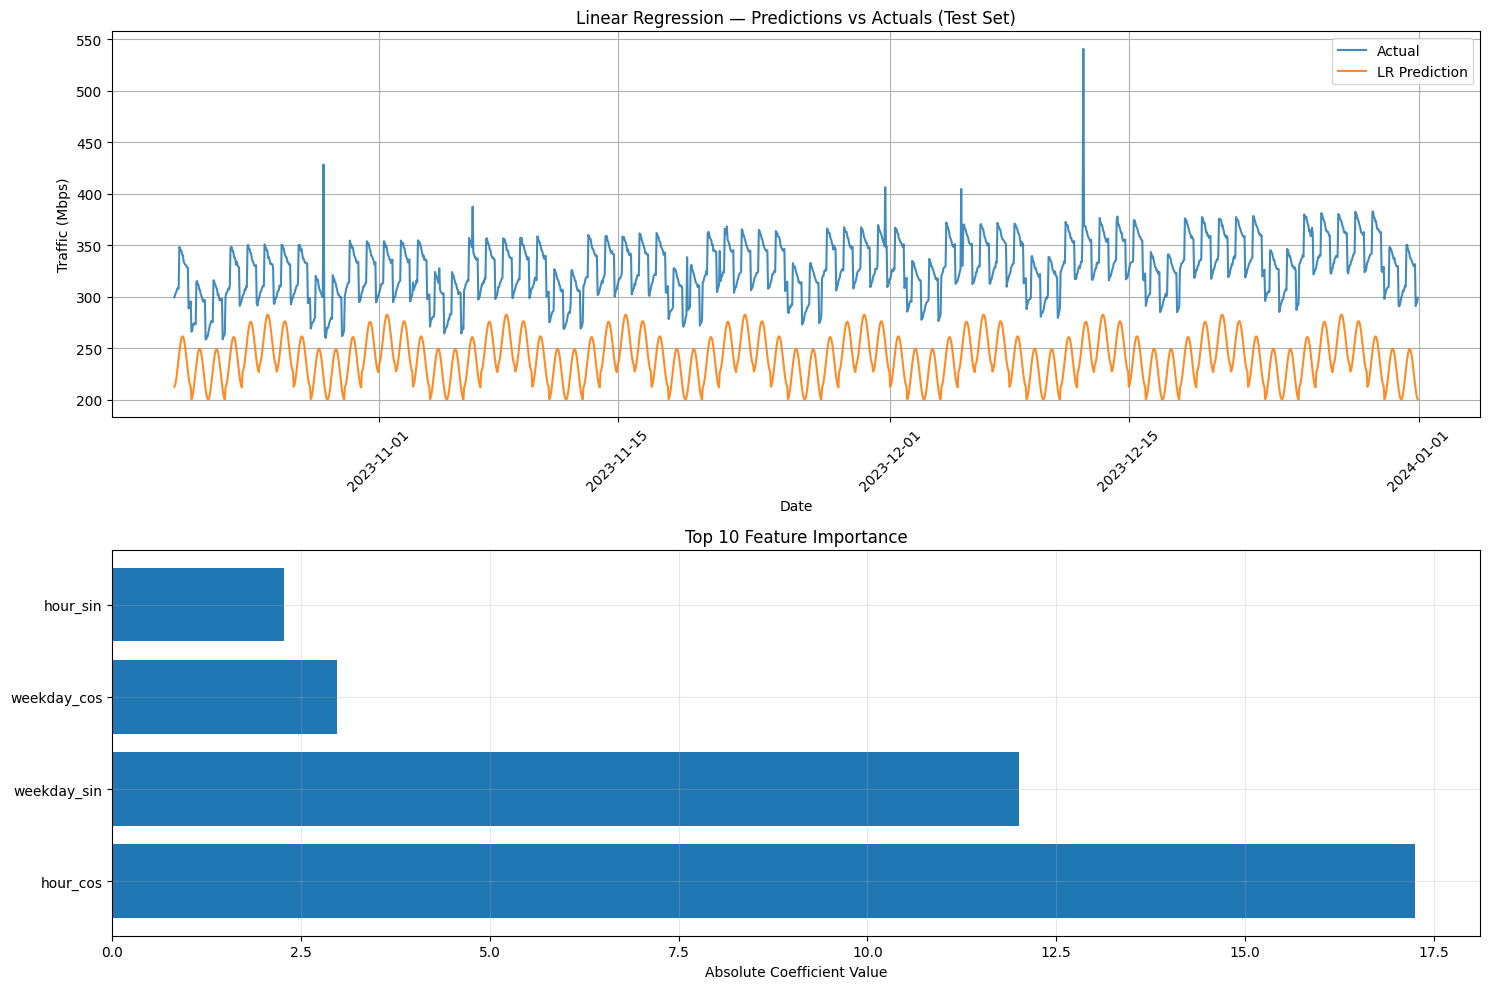

In [13]:
lr_model, scaler, lr_predictions, lr_test_index, lr_metrics = build_linear_regression_model(train_data, test_data)

# PART 6: MODEL 3 - SIMPLE LSTM NEURAL NETWORK

In [14]:
def build_simple_lstm_model(train_data, test_data, sequence_length=24):
    """Build a simple LSTM model for time series prediction"""

    print("\n" + "="*50)
    print("SIMPLE LSTM MODEL (Conceptual Implementation)")
    print("="*50)

    print("Note: This is a simplified LSTM implementation")